In [1]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical


In [2]:
# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Предобработка данных
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [4]:
# Разделение на тренировочный и валидационный наборы
split = 59000
x_val, y_val = x_train[split:], y_train[split:]
x_train, y_train = x_train[:split], y_train[:split]

In [37]:
# 2. Функция обучения 
def train_model(X, y, X_val, y_val, 
                hidden_size=[512], 
                learning_rate=0.001, epochs=10):
    input_size = X.shape[1]
    output_size = y.shape[1]
    samples = X.shape[0]
    hidden_sizes = [*hidden_size, output_size]
    layers = len(hidden_sizes)
    W = []
    b = []
    np.random.seed(42)
    for i in range(0, layers):
        # Регуляризация Ксавьера
        W_i = np.random.randn(input_size     if i == 0          else hidden_size[i - 1], 
                              hidden_size[i] if i != layers - 1 else output_size) 
        W_i *= np.sqrt(2./(input_size if i == 0 else hidden_size[i - 1]))

        b_i = np.zeros(hidden_size[i] if i != layers - 1 else output_size)

        W.append(W_i)
        b.append(b_i)

    # Функции активации
    softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    relu = lambda x: np.maximum(x, 0)
    relu_derivative = lambda x: np.where(x > 0, 1, 0)
    history = {
        'loss': [],
        'accuracy': []
    }

    for epoch in range(epochs):
        # Перемешивание данных
        indices = np.random.permutation(samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Прямое распространение
        h = [X_shuffled]
        z_list = []
        for i in range(layers):
            z = h[i] @ W[i] + b[i]
            z_list.append(z)
            h.append(relu(z) if i < layers-1 else z) 

        # Вычисление потерь
        y_pred = softmax(z_list[-1])
        loss = -np.mean(y_shuffled * np.log(y_pred + 1e-8))

        # Обратное распространение
        dl = (y_pred - y_shuffled) / samples

        for i in reversed(range(layers)):
            if i != layers - 1: dl *= relu_derivative(z_list[i])
            
            # Вычисление градиентов
            dW = h[i].T @ dl
            db = np.sum(dl, axis=0)
            
            # Обновление весов и смещений
            W[i] -= learning_rate * dW
            b[i] -= learning_rate * db
            
            # Передача градиента предыдущему слою
            if i > 0: dl = dl @ W[i].T

        # Вычисление метрик
        train_preds = np.argmax(y_pred, axis=1)
        train_labels = np.argmax(y_shuffled, axis=1)
        train_acc = np.mean(train_preds == train_labels)
        
        # Валидационная точность
        z_val = X_val
        for i in range(layers):
            z_val = z_val @ W[i] + b[i]
            if i != layers - 1:
                z_val = relu(z_val)
        y_val_pred = softmax(z_val)
        val_preds = np.argmax(y_val_pred, axis=1)
        val_labels = np.argmax(y_val, axis=1)
        val_acc = np.mean(val_preds == val_labels)

        history['loss'].append(loss)
        history['accuracy'].append(train_acc)

        print(f'Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | '
              f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')
        

    return W, b, layers, history



In [39]:
W, b, layers, history = train_model(
    X=x_train,
    y=y_train,
    X_val=x_val,
    y_val=y_val,
    hidden_size=[512],
    learning_rate=0.1,
    epochs=50
)

Epoch 1/50 | Loss: 0.2350 | Train Acc: 0.1357 | Val Acc: 0.2550
Epoch 2/50 | Loss: 0.2183 | Train Acc: 0.2670 | Val Acc: 0.4020
Epoch 3/50 | Loss: 0.2052 | Train Acc: 0.3876 | Val Acc: 0.4950
Epoch 4/50 | Loss: 0.1935 | Train Acc: 0.4799 | Val Acc: 0.5800
Epoch 5/50 | Loss: 0.1829 | Train Acc: 0.5468 | Val Acc: 0.6370
Epoch 6/50 | Loss: 0.1732 | Train Acc: 0.5953 | Val Acc: 0.6830
Epoch 7/50 | Loss: 0.1643 | Train Acc: 0.6314 | Val Acc: 0.7160
Epoch 8/50 | Loss: 0.1561 | Train Acc: 0.6592 | Val Acc: 0.7440
Epoch 9/50 | Loss: 0.1487 | Train Acc: 0.6815 | Val Acc: 0.7610
Epoch 10/50 | Loss: 0.1419 | Train Acc: 0.7009 | Val Acc: 0.7810
Epoch 11/50 | Loss: 0.1356 | Train Acc: 0.7171 | Val Acc: 0.7940
Epoch 12/50 | Loss: 0.1299 | Train Acc: 0.7303 | Val Acc: 0.8040
Epoch 13/50 | Loss: 0.1247 | Train Acc: 0.7419 | Val Acc: 0.8120
Epoch 14/50 | Loss: 0.1199 | Train Acc: 0.7524 | Val Acc: 0.8260
Epoch 15/50 | Loss: 0.1155 | Train Acc: 0.7616 | Val Acc: 0.8350
Epoch 16/50 | Loss: 0.1114 | Train

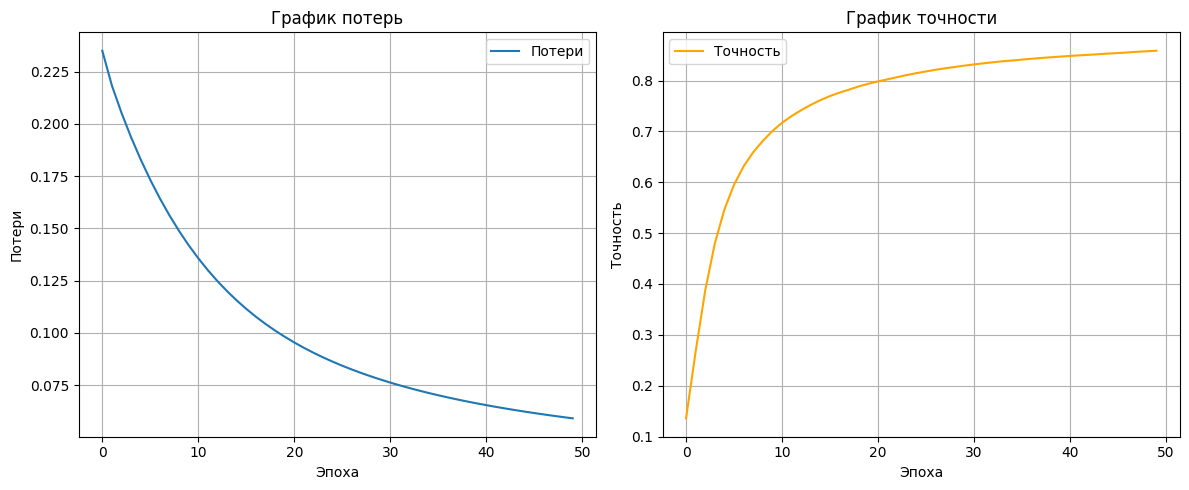

In [43]:
import matplotlib.pyplot as plt

# Построение графика потерь
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Потери')
plt.title('График потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.grid(True)
plt.legend()

# Построение графика точности
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Точность', color='orange')
plt.title('График точности')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.grid(True)
plt.legend()

# Показать оба графика
plt.tight_layout()
plt.show()

In [44]:
# Сохранение данных в файл
np.savez('model_weights.npz', layers, *W, *b)